# Stock Valuation Recommendation System
* Student Name: Evan Callaghan
* Student Pace: Part Time
* Scheduled Project Review Date/Time:
* Instructor Name: Mark Barbour

## Business Understanding
*Callaghan Investments* has created a new stock recommendation service for their value investors. This new service *Stock Value Proximity* allows the user to input a stock ticker and they will be provided with 5 stocks with a similar value. The overall 'value' given is modeled based on the following financial metrics: 
* Trailing P/E Ratio
* Forward P/E Ratio
* Price to Book Ratio
* Earnings Per Share Forward
* Return on Equity
* Debt to Equity Ratio
* Operating Margin
* Price to Sales Ratio
* Quick Ratio
* Enterprise Value to EBITDA
* Free Cash Flow Yield

These 11 financial metrics are combined into a model that groups stocks based on their similarities. The model looks at how close the stocks are to each other in terms of their values, and then organizes them into clusters of stocks that share similar financial characteristics. Below are some potential use-cases of this product:
* Use-Case 1: Find similarly valued stocks to purchase
* * An investor has researched the metrics, decided that 'AAPL' is undervalued, and has the intent of purchasing shares of 'AAPL' in the hopes of an eventual increase in share price. As this strategy has worked for them before, the investor desires to find more stocks with very similar value to 'AAPL' in order to find other undervalued stocks to purchase for potential future profit.
* Use-Case 2: The Short Seller
* * An investor has analyzed 'AAPL' stock, decided that it is overvalued, and has decided to short the stock until it reaches a fair market value. However, with 'AAPL' coming out with a new product soon, the investor is unsure if the new product launch will catapult 'AAPL' into even further overvalued territory, ruining his shorting strategy. In order to find similarly overvalued stocks which don't have upcoming bullish news events, the investor uses this program to find other stocks which are just as overvalued in order to see if there is a better stock to short. 

# Data Understanding
The stocks and financial metrics to build this recommendation system comes from two sources:
* NASDAQ: https://www.nasdaq.com/market-activity/stocks/screener
* Yahoo Finance: yfinance python library

# Data Preparation: Loading and Preprocessing Data 
We import stock names, stock tickers, and market cap information in the form of a CSV file from NASDAQ and format it into a DataFrame. Upon doing this, we only keep stocks that are common shares and drop all other security types. After this, we load 15 financial metrics for these stocks from yfinance into a separate DataFrame. Then, we drop any financial metrics which were unavailable from yahoo finance, and merge the DataFrames together so that the stocks and financial metrics are all in one spot. Finally, we will drop any stocks of which the majority of their financial metrics are unavailable. 

In [1]:
# Import Necessary Libraries

import pandas as pd 
import yfinance as yf 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import warnings

In [2]:
# Supress warnings from being displayed

# Ignore SettingWithCopyWarning
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ignore UserWarning (including FixedFormatter warning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
# Loading csv file of stocks and market cap

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv' 
df_stocks = pd.read_csv(csv_file_path)

# Inspect the DataFrame to understand its structure
print(df_stocks.head())

# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df_stocks = df_stocks[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df_stocks['Market Cap'] = df_stocks['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_stocks = df_stocks.sort_values(by='Market Cap', ascending=False).head(2000)                                                                        
print(df_stocks.head())


  Symbol                                               Name Last Sale  \
0      A             Agilent Technologies Inc. Common Stock   $138.31   
1     AA                    Alcoa Corporation Common Stock     $34.50   
2   AACG   ATA Creativity Global American Depositary Shares   $0.5025   
3   AACT  Ares Acquisition Corporation II Class A Ordina...    $10.80   
4   AADI                  Aadi Bioscience Inc. Common Stock     $1.88   

   Net Change % Change    Market Cap        Country  IPO Year    Volume  \
0      1.0000   0.728%  3.974029e+10  United States    1999.0    887040   
1      1.9800   6.089%  8.912735e+09  United States    2016.0  10730428   
2     -0.0275  -5.189%  1.608006e+07          China    2008.0     25043   
3      0.0200   0.186%  0.000000e+00            NaN    2023.0     35074   
4      0.0800   4.444%  4.627589e+07  United States       NaN     81942   

        Sector                                          Industry  
0  Industrials  Biotechnology: Laboratory A

In [4]:
# Reset the index of the DataFrame and drop the old index
df_stocks.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_stocks.index = df_stocks.index + 1

# Display the first few rows of the updated DataFrame
df_stocks.tail()

,Symbol,Name,Market Cap
1996,MBC,MasterBrand Inc. Common Stock,2.147470e+09
1997,GRND,Grindr Inc. Common Stock,2.147105e+09
1998,ASAI,Sendas Distribuidora S A ADS,2.146711e+09
1999,NBTB,NBT Bancorp Inc. Common Stock,2.126482e+09
2000,ENVA,Enova International Inc. Common Stock,2.125436e+09


In [5]:
# Remove all except common stocks 

# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_stocks['Name'] = df_stocks['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", 
                 "Registry Shares", "Depositary Shares"
]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, 
# there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_stocks = df_stocks[~df_stocks['Name'].str.contains(pattern, case=False, 
                                                        na=False)
]

# Display the filtered DataFrame
df_stocks.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
6,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


In [6]:
# Reset the index to account for the new filtering
df_stocks.reset_index(drop=True, inplace=True)
df_stocks.index = df_stocks.index + 1
df_stocks.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
5,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


In [7]:
# Count the rows in our new DataFrame to ensure that filtering was done
# and to see how many rows we have left
df_stocks.count()

Symbol        1862
Name          1862
Market Cap    1862
dtype: int64

In [ ]:
# Here is the list of valuation ratios we are using:
    # 1. P/E ratio 2. Price to book ratio 3. Debt to Equity Ratio 4. Free Cash Flow 
    # 5. Price/Earnings to Grow Ratio 6. Return on Equity 7. Debt to Capital Ratio
    # 8. Interest Coverage Ratio 9. Enterprice value to EBIT 10. Operating Margin
    # 11. Quick ratio 12. Price to Sales Ratio 13. Earnings per Share

# There is a CSV file of this information provided, as this code is
# computationally intensive

# Function to get various financial ratios
def get_financial_data(symbol):
    try:
        stock = yf.Ticker(symbol)
        info = stock.info
        
        # Define the parameters and their corresponding keys in the info dictionary
        parameters = {
            'Trailing P/E Ratio': 'trailingPE',
            'Forward P/E Ratio': 'forwardPE',
            'Price to Book Ratio': 'priceToBook',
            'Earnings Per Share Trailing': 'epsTrailingTwelveMonths',
            'Earnings Per Share Forward': 'forwardEps',
            'Return on Equity': 'returnOnEquity',
            'Debt to Equity Ratio': 'debtToEquity',
            'Free Cash Flow': 'freeCashflow',
            'Operating Margin': 'operatingMargins',
            'Price to Sales Ratio': 'priceToSalesTrailing12Months',
            'Quick Ratio': 'quickRatio',
            'Interest Coverage Ratio': 'interestCoverageRatio',
            'Enterprise Value': 'enterpriseValue',
            'Enterprise Value to EBITDA': 'enterpriseToEbitda',
            'PEG Ratio': 'pegRatio'
        }
        
        # Extract data
        data = {param: info.get(key, 'Not Available') for param, key in parameters.items()}

        # Extract Total Debt and Total Stockholder Equity from the balance sheet
        balance_sheet = stock.balance_sheet
        if 'Long Term Debt' in balance_sheet.index:
            data['Total Debt'] = balance_sheet.loc['Long Term Debt'].iloc[0]
        else:
            data['Total Debt'] = 'Not Available'
        
        if 'Total Stockholder Equity' in balance_sheet.index:
            data['Total Stockholder Equity'] = balance_sheet.loc['Total Stockholder Equity'].iloc[0]
        else:
            data['Total Stockholder Equity'] = 'Not Available'
        
        return data
    except Exception as e:
        return {'Symbol': symbol, 'Error': str(e)}

# List of stock symbols
stock_symbols = df_stocks['Symbol'].tolist()

# Create lists to store data
all_data = []

# Fetch financial data for each stock
for symbol in stock_symbols:
    data = get_financial_data(symbol)
    data['Symbol'] = symbol
    all_data.append(data)

# Create a DataFrame from the collected data
df_financial_parameters = pd.DataFrame(all_data)

# Reset the index to start at 1 for readability
df_financial_parameters.index = df_financial_parameters.index + 1

# Display the DataFrame
df_financial_parameters.head()


In [ ]:
# Save the DataFrame as a CSV file for later use
df_financial_parameters.to_csv('df_financial_parameters.csv', index=False)

In [8]:
# Extract the CSV file from our files and convert it into a DataFrame
df_financial_parameters = pd.read_csv('df_financial_parameters.csv')
df_financial_parameters.head()
                                

,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Trailing,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Operating Margin,Price to Sales Ratio,Quick Ratio,Interest Coverage Ratio,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Total Debt,Total Stockholder Equity,Symbol,Error
0,37.88797,27.693354,61.051235,Not Available,8.31,1.5741299,209.059,110846001152,0.31171,8.844263,0.745,Not Available,3530225090560,26.216,Not Available,85750000000.0,Not Available,AAPL,NaN
1,35.457024,28.583687,11.088052,Not Available,14.95,0.35604,33.657,61280874496,0.46583998,12.548828,1.163,Not Available,3208195866624,23.494,Not Available,42688000000.0,Not Available,MSFT,NaN
2,54.430832,30.964718,78.96216,Not Available,4.12,1.23767,17.221,33725874176,0.62057,35.01841,3.503,Not Available,3553896693760,58.085,Not Available,8459000000.0,Not Available,NVDA,NaN
3,25.960264,21.876465,7.652364,Not Available,8.96,0.32101002,9.324,41104498688,0.32312,7.0847635,1.761,Not Available,2335294881792,18.914,Not Available,11870000000.0,Not Available,GOOGL,NaN
4,48.27778,36.496384,9.164063,Not Available,6.15,0.22558,61.175,54328250368,0.109589994,3.8310788,0.827,Not Available,2446245494784,21.923,Not Available,58314000000.0,Not Available,AMZN,NaN


In [9]:
# Drop any columns that appear to have 'Not Available' 
# or 'NaN' values for the majority of the stocks
df_financial_parameters = df_financial_parameters.drop(columns = ["Earnings Per Share Trailing", 
                                                      "PEG Ratio", 
                                                      "Total Stockholder Equity", 
                                                      "Interest Coverage Ratio",  
                                                      "Error"], axis=1)
df_financial_parameters.head()

,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Operating Margin,Price to Sales Ratio,Quick Ratio,Enterprise Value,Enterprise Value to EBITDA,Total Debt,Symbol
0,37.88797,27.693354,61.051235,8.31,1.5741299,209.059,110846001152,0.31171,8.844263,0.745,3530225090560,26.216,85750000000.0,AAPL
1,35.457024,28.583687,11.088052,14.95,0.35604,33.657,61280874496,0.46583998,12.548828,1.163,3208195866624,23.494,42688000000.0,MSFT
2,54.430832,30.964718,78.96216,4.12,1.23767,17.221,33725874176,0.62057,35.01841,3.503,3553896693760,58.085,8459000000.0,NVDA
3,25.960264,21.876465,7.652364,8.96,0.32101002,9.324,41104498688,0.32312,7.0847635,1.761,2335294881792,18.914,11870000000.0,GOOGL
4,48.27778,36.496384,9.164063,6.15,0.22558,61.175,54328250368,0.109589994,3.8310788,0.827,2446245494784,21.923,58314000000.0,AMZN


In [10]:
# Merge DataFrames based on shared column 'Symbol'
df_merged_stock_data = pd.merge(df_stocks, df_financial_parameters, on="Symbol")
df_merged_stock_data.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Operating Margin,Price to Sales Ratio,Quick Ratio,Enterprise Value,Enterprise Value to EBITDA,Total Debt
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.88797,27.693354,61.051235,8.31,1.5741299,209.059,110846001152,0.31171,8.844263,0.745,3530225090560,26.216,85750000000.0
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.457024,28.583687,11.088052,14.95,0.35604,33.657,61280874496,0.46583998,12.548828,1.163,3208195866624,23.494,42688000000.0
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,54.430832,30.964718,78.96216,4.12,1.23767,17.221,33725874176,0.62057,35.01841,3.503,3553896693760,58.085,8459000000.0
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,25.960264,21.876465,7.652364,8.96,0.32101002,9.324,41104498688,0.32312,7.0847635,1.761,2335294881792,18.914,11870000000.0
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,48.27778,36.496384,9.164063,6.15,0.22558,61.175,54328250368,0.109589994,3.8310788,0.827,2446245494784,21.923,58314000000.0


# Data Preparation: Median Imputation
Some stocks have missing values, but still have the majority of their financial metrics. We cannot run the model with incomplete values, so we will fill in those values using median imputation and replace it with the median value of the column in order to keep the distribution of values as close as possible. 

In [11]:
# Replace 'Not Available' with pd.NA to easily filter the data
df_merged_stock_data.replace('Not Available', pd.NA, inplace=True)

# Put all valuation columns into a variable, dropping the descriptive 'Name' 
# and 'Symbol' columns
valuation_columns = df_merged_stock_data.drop(['Name', 'Symbol'], axis=1).columns

# Remove rows which have 11 or more missing values in the valuation columns
df_stock_data_filtered = df_merged_stock_data[
    df_merged_stock_data[valuation_columns]
    .isna().sum(axis=1) < 11]

# Print the original number of rows and the newly filtered rows
print(f"Original number of rows: {len(df_merged_stock_data)}")

print(f"Number of rows after filtering: {len(df_stock_data_filtered)}")

Original number of rows: 1862
Number of rows after filtering: 1345


In [12]:
# Get a list of all column names in the DataFrame
columns_to_impute = df_stock_data_filtered.count().keys().tolist()

# Exclude non-numeric columns from the list 
columns_to_impute = [col for col in columns_to_impute if col not in ['Symbol', 'Name']]

# Convert columns to numeric and impute missing values with the median 
# of the respective column
for col in columns_to_impute:
    df_stock_data_filtered[col] = pd.to_numeric(df_stock_data_filtered[col], 
                                                 errors ='coerce')
    median_value = df_stock_data_filtered[col].median()
    df_stock_data_filtered[col].fillna(median_value, inplace=True)

df_stock_data_filtered.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Operating Margin,Price to Sales Ratio,Quick Ratio,Enterprise Value,Enterprise Value to EBITDA,Total Debt
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.887970,27.693354,61.051235,8.31,1.57413,209.059,1.108460e+11,0.31171,8.844263,0.745,3.530225e+12,26.216,8.575000e+10
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.457024,28.583687,11.088052,14.95,0.35604,33.657,6.128087e+10,0.46584,12.548828,1.163,3.208196e+12,23.494,4.268800e+10
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,54.430832,30.964718,78.962160,4.12,1.23767,17.221,3.372587e+10,0.62057,35.018410,3.503,3.553897e+12,58.085,8.459000e+09
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,25.960264,21.876465,7.652364,8.96,0.32101,9.324,4.110450e+10,0.32312,7.084764,1.761,2.335295e+12,18.914,1.187000e+10
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,48.277780,36.496384,9.164063,6.15,0.22558,61.175,5.432825e+10,0.10959,3.831079,0.827,2.446245e+12,21.923,5.831400e+10


In [13]:
# Drop Total Debt column because we had to drop total stock holder equity 

df_stock_data_filtered = df_stock_data_filtered.drop(columns = ["Total Debt"], axis=1)
df_stock_data_filtered.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Operating Margin,Price to Sales Ratio,Quick Ratio,Enterprise Value,Enterprise Value to EBITDA
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.887970,27.693354,61.051235,8.31,1.57413,209.059,1.108460e+11,0.31171,8.844263,0.745,3.530225e+12,26.216
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.457024,28.583687,11.088052,14.95,0.35604,33.657,6.128087e+10,0.46584,12.548828,1.163,3.208196e+12,23.494
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,54.430832,30.964718,78.962160,4.12,1.23767,17.221,3.372587e+10,0.62057,35.018410,3.503,3.553897e+12,58.085
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,25.960264,21.876465,7.652364,8.96,0.32101,9.324,4.110450e+10,0.32312,7.084764,1.761,2.335295e+12,18.914
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,48.277780,36.496384,9.164063,6.15,0.22558,61.175,5.432825e+10,0.10959,3.831079,0.827,2.446245e+12,21.923


# Data Preparation: Create Free Cash Flow Yield Column
* Free Cash Flow Yield = Free Cash Flow / Enterprise Value
Free Cash Flow Yield could not be pulled directly from yahooo finance, but Free Cash Flow and Enterprise Value could be, so we created the 'Free Cash Flow Yield' metric column ourselves using the Free Cash Flow Yield equation. Upon creating this, we drop the Free Cash Flow and Enterprise Value columns as that information is no longer needed. 

In [14]:
# Free Cash Flow Yield = Free cash FLow / Enterprise Value
df_stock_data_filtered["Free Cash Flow Yield"] = df_stock_data_filtered["Free Cash Flow"] / df_stock_data_filtered["Enterprise Value"]
df_stock_data_filtered.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Operating Margin,Price to Sales Ratio,Quick Ratio,Enterprise Value,Enterprise Value to EBITDA,Free Cash Flow Yield
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.887970,27.693354,61.051235,8.31,1.57413,209.059,1.108460e+11,0.31171,8.844263,0.745,3.530225e+12,26.216,0.031399
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.457024,28.583687,11.088052,14.95,0.35604,33.657,6.128087e+10,0.46584,12.548828,1.163,3.208196e+12,23.494,0.019101
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,54.430832,30.964718,78.962160,4.12,1.23767,17.221,3.372587e+10,0.62057,35.018410,3.503,3.553897e+12,58.085,0.009490
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,25.960264,21.876465,7.652364,8.96,0.32101,9.324,4.110450e+10,0.32312,7.084764,1.761,2.335295e+12,18.914,0.017601
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,48.277780,36.496384,9.164063,6.15,0.22558,61.175,5.432825e+10,0.10959,3.831079,0.827,2.446245e+12,21.923,0.022209


In [15]:
# Since we now have freee cash flow yield, we can drop enterprise value and free cash flow
df_stock_data_filtered = df_stock_data_filtered.drop(columns = ["Free Cash Flow", "Enterprise Value"], axis=1)
df_stock_data_filtered.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Operating Margin,Price to Sales Ratio,Quick Ratio,Enterprise Value to EBITDA,Free Cash Flow Yield
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.887970,27.693354,61.051235,8.31,1.57413,209.059,0.31171,8.844263,0.745,26.216,0.031399
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.457024,28.583687,11.088052,14.95,0.35604,33.657,0.46584,12.548828,1.163,23.494,0.019101
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,54.430832,30.964718,78.962160,4.12,1.23767,17.221,0.62057,35.018410,3.503,58.085,0.009490
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,25.960264,21.876465,7.652364,8.96,0.32101,9.324,0.32312,7.084764,1.761,18.914,0.017601
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,48.277780,36.496384,9.164063,6.15,0.22558,61.175,0.10959,3.831079,0.827,21.923,0.022209


# Data Preparation: Value Measures
For each of these financial valuation parameters, they have a certain range of values with which they are either undervalued, overvalued, or fair valued. For potential use, we researched the range of all these financial parameters and assigned whether they were 'Overvalued', 'Undervalued', or 'Fair Value', according to their current measurement. 

In [16]:
# Define thresholds for each parameter
valuation_thresholds = {
    "Trailing P/E Ratio": {"Undervalued": (None, 10), "Fair Value": (10, 20), "Overvalued": (20, None)},
    "Forward P/E Ratio": {"Undervalued": (None, 10), "Fair Value": (10, 20), "Overvalued": (20, None)},
    "Price to Book Ratio": {"Undervalued": (None, 1), "Fair Value": (1, 1), "Overvalued": (1, None)},
    "Earnings Per Share Forward": {"Undervalued": (None, 5), "Fair Value": (5, 5), "Overvalued": (5, None)},
    "Return on Equity": {"Undervalued": (15, None), "Fair Value": (5, 15), "Overvalued": (None, 5)},
    "Debt to Equity Ratio": {"Undervalued": (None, 0.5), "Fair Value": (0.5, 2.0), "Overvalued": (2.0, None)},
    "Operating Margin": {"Undervalued": (15, None), "Fair Value": (5, 15), "Overvalued": (None, 5)},
    "Price to Sales Ratio": {"Undervalued": (None, 1), "Fair Value": (1, 3), "Overvalued": (3, None)},
    "Quick Ratio": {"Undervalued": (1.5, None), "Fair Value": (1, 1.5), "Overvalued": (None, 1)},
    "Enterprise Value to EBITDA": {"Undervalued": (None, 6), "Fair Value": (6, 10), "Overvalued": (10, None)},
    "Free Cash Flow Yield": {"Undervalued": (0.05, None), "Fair Value": (0.03, 0.05), "Overvalued": (None, 0.03)}
}


In [17]:
# Function to categorize a value based on the thresholds dictionary.
def categorize_value(value, thresholds):
    
    if thresholds["Undervalued"][0] is None and value < thresholds["Undervalued"][1]:
        return "Undervalued"
    elif thresholds["Fair Value"][0] <= value <= thresholds["Fair Value"][1]:
        return "Fair Value"
    elif thresholds["Overvalued"][1] is None and value > thresholds["Overvalued"][0]:
        return "Overvalued"
    return "Undervalued"  # Default category if no match


In [18]:
# Categorize each valuation parameter
for param, thresholds in valuation_thresholds.items():
    column_name = f"{param} Category"  # Create a new column for the categories
    df_stock_data_filtered[column_name] = df_stock_data_filtered[param].apply(lambda x: categorize_value(x, thresholds))


In [19]:
df_stock_data_filtered.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Operating Margin,...,Forward P/E Ratio Category,Price to Book Ratio Category,Earnings Per Share Forward Category,Return on Equity Category,Debt to Equity Ratio Category,Operating Margin Category,Price to Sales Ratio Category,Quick Ratio Category,Enterprise Value to EBITDA Category,Free Cash Flow Yield Category
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.887970,27.693354,61.051235,8.31,1.57413,209.059,0.31171,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Fair Value
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.457024,28.583687,11.088052,14.95,0.35604,33.657,0.46584,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Fair Value,Overvalued,Undervalued
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,54.430832,30.964718,78.962160,4.12,1.23767,17.221,0.62057,...,Overvalued,Overvalued,Undervalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,25.960264,21.876465,7.652364,8.96,0.32101,9.324,0.32312,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,48.277780,36.496384,9.164063,6.15,0.22558,61.175,0.10959,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued


# Financial Parameter Valuation Ranges

1. P/E ratio
* Links
* *https://www.nasdaq.com/articles/back-to-value-investing-basics:-the-p-e-ratio
* * "https://en.macromicro.me/collections/5749/industry-forward-pe-ratio/48243/s5cond-forward-pe-ratio"
* * "https://worldperatio.com/sp-500-sectors/"
    

3. Price to Book Ratio
* Links
* * https://www.investopedia.com/ask/answers/040815/what-average-pricetobook-ratio-bank.asp
* * https://siblisresearch.com/data/price-to-book-sector/
 
4. Debt to Equity Ratio
* Link
* * https://www.investopedia.com/ask/answers/040915/what-considered-good-net-debttoequity-ratio.asp
    Overall Range:
* * https://eqvista.com/debt-to-equity-ratio-by-industry/
* * https://csimarket.com/screening/index.php?s=de&pageS=1&fis=   

6. Free Cash Flow 
* Link
* * https://www.investopedia.com/terms/f/freecashflow.asp
    Overall Range:
* * https://csimarket.com/Industry/industry_growth_rates.php?s=1000
* * https://www.riskconcern.com/market-data-and-statistics/free-cash-flow-yield-by-sector-%26-industry-in-the-u.s.   

7. Price/Earnings to Growth Ratio
* Link
* * https://www.investopedia.com/ask/answers/012715/what-considered-good-peg-price-earnings-growth-ratio.asp
* *  https://www.fool.com/terms/p/peg-ratio/

8. Return on Equity 
* Link
* * https://www.investopedia.com/terms/r/returnonequity.asp
  * https://csimarket.com/screening/index.php?s=roe&pageS=1&fis=
  * https://www.investopedia.com/ask/answers/071715/what-average-return-equity-company-retail-sector.asp
  * https://www.investopedia.com/ask/answers/070914/how-do-you-calculate-return-equity-roe.asp

9. Debt to Capital Ratio
* Link
* * https://www.investopedia.com/terms/d/debt-to-capitalratio.asp
  * https://www.riskconcern.com/market-data-and-statistics/debt-to-assets-ratio%2Fdebt-ratio-by-sector-%26-industry-in-the-u.s.

10. Interest Coverage Ratio
* Link
* * https://www.investopedia.com/terms/i/interestcoverageratio.asp
  * https://www.wallstreetoasis.com/resources/skills/finance/interest-coverage-ratio
  * https://csimarket.com/screening/index.php?s=ic
    
11. Enterprise value to EBITDA
* Link
* * https://www.investopedia.com/ask/answers/072715/what-considered-healthy-evebitda.asp
  * https://siblisresearch.com/data/ev-ebitda-multiple/
                
12. Operating Margin
* Link
* * https://www.investopedia.com/terms/o/operatingmargin.asp
  * https://www.gurufocus.com/economic_indicators/4237/sp-500-operating-margin-information-technology
   
13. Quick Ratio
* Link
* * https://www.investopedia.com/terms/q/quickratio.asp
    
14. Price to Sales Ratio
* Link
* * https://www.investopedia.com/terms/p/price-to-salesratio.asp
  * https://eqvista.com/price-to-sales-ratio-by-industry/
    

15. Earnings Per Share
* Link
* * https://www.investopedia.com/terms/e/eps.asp
   


|       Valuation Paramater       |   Undervalued (Less Risky)  | Fair Value (Fair Risk) | Overvalued (More Risky) |
|:-------------------------------:|:---------------------------:|:----------------------:|:-----------------------:|
| 1. P/E ratio                    | < 10                        | > 10 and < 20          | > 20                    |  
| 2. Price to book ratio          | < 1                         | = 1                    | > 1                     |
| 3. Debt to Equity Ratio         | < 0.5                       | > 0.5 and < 2.0        | < 2.0                   |
| 4. Free Cash Flow               | > 5%                        | > 3% and < 5%          | < 3%                    |
| 5. Price/Earnings to Grow Ratio | < 1                         | = 1                    | > 1                     |
| 6. Return on Equity             | > 15%                       | > 5% and < 15%         | < 5%                    |
| 7. Debt to Capital Ratio        | < 0.2                       | > 0.2 and < 0.5        | > 0.5                   |
| 8. Interest Coverage Ratio      | > 5                         | > 1.5 < 5              | < 1.5                   |
| 9. Enterprice value to EBIT     | < 6                         | > 6 < 10               | > 10                    |
| 10. Operating Margin            | > 15                        | > 5 < 15               | < 5                     |
| 11. Quick ratio                 | > 1.5                       | > 1 < 1.5              | < 1                     |
| 12. Price to Sales Ratio        | < 1                         | > 1 < 3                | > 3                     |
| 13. Earnings per Share          | < 5                         | = 5                    | > 5                     |

# Data Preparation: Scaling
In order to prevent certain features from creating bias in our model because they are on a larger scale than other features, we transform the values to put them into a consistent range or scale. This process is going to normalize our values so that they have a mean of 0 and a standard deviation of 1. Before this, we first had to find any column values which were infinite and replace them using median imputation. Now that our data is preprocessed and scaled, we can begin the modeling process. 

In [20]:
# Upon trying to scale our values for modeling, we were given an error saying 
# some of our values
# were infinite
# This identifies and prints out rows with infinite values

infinity_values = df_stock_data_filtered[["Market Cap", "Trailing P/E Ratio", "Forward P/E Ratio", "Price to Book Ratio", 
                                           "Earnings Per Share Forward", "Return on Equity", "Debt to Equity Ratio", 
                                           "Operating Margin", "Price to Sales Ratio", "Quick Ratio", "Enterprise Value to EBITDA", 
                                           "Free Cash Flow Yield"]].applymap(np.isinf)

# Print out any rows with infinite values
print(df_stock_data_filtered[infinity_values.any(axis=1)])

     Symbol                                               Name    Market Cap  \
1103   CWAN  Clearwater Analytics Holdings Inc. Class A Com...  6.037394e+09   
1322   DNLI              Denali Therapeutics Inc. Common Stock  4.342202e+09   

      Trailing P/E Ratio  Forward P/E Ratio  Price to Book Ratio  \
1103                 inf          52.641480            15.231355   
1322           23.226196          -7.557222             2.392538   

      Earnings Per Share Forward  Return on Equity  Debt to Equity Ratio  \
1103                        0.53           0.00907                16.205   
1322                       -2.75          -0.35086                 3.987   

      Operating Margin  ...  Forward P/E Ratio Category  \
1103           0.06335  ...                  Overvalued   
1322           0.15774  ...                 Undervalued   

      Price to Book Ratio Category  Earnings Per Share Forward Category  \
1103                    Overvalued                          Undervalued 

In [21]:
# Replace all infinite values the median column values

columns_with_inf = ["Trailing P/E Ratio", "Forward P/E Ratio", "Price to Book Ratio", 
                     "Earnings Per Share Forward", "Return on Equity", "Debt to Equity Ratio", 
                    "Operating Margin", "Price to Sales Ratio", "Quick Ratio", "Enterprise Value to EBITDA", 
                    "Free Cash Flow Yield"]
df_stock_data_filtered[columns_with_inf] = df_stock_data_filtered[
    columns_with_inf].replace([np.inf, -np.inf], np.nan)
df_stock_data_filtered[columns_with_inf] = df_stock_data_filtered[
    columns_with_inf].fillna(df_stock_data_filtered[columns_with_inf].median())
df_stock_data_filtered.count()

Symbol                                 1345
Name                                   1345
Market Cap                             1345
Trailing P/E Ratio                     1345
Forward P/E Ratio                      1345
Price to Book Ratio                    1345
Earnings Per Share Forward             1345
Return on Equity                       1345
Debt to Equity Ratio                   1345
Operating Margin                       1345
Price to Sales Ratio                   1345
Quick Ratio                            1345
Enterprise Value to EBITDA             1345
Free Cash Flow Yield                   1345
Trailing P/E Ratio Category            1345
Forward P/E Ratio Category             1345
Price to Book Ratio Category           1345
Earnings Per Share Forward Category    1345
Return on Equity Category              1345
Debt to Equity Ratio Category          1345
Operating Margin Category              1345
Price to Sales Ratio Category          1345
Quick Ratio Category            

In [22]:
# Module to standardize numerical data by scaling to unit variance

# Used to perform scaling transformation on the data
scaler = StandardScaler()

df_stock_data_filtered = df_stock_data_filtered.copy()
df_stock_data_filtered[["Trailing P/E Ratio", "Forward P/E Ratio", "Price to Book Ratio", "Earnings Per Share Forward", 
                           "Return on Equity", "Debt to Equity Ratio", "Operating Margin", "Price to Sales Ratio", 
                           "Quick Ratio", "Enterprise Value to EBITDA", "Free Cash Flow Yield"]]=scaler.fit_transform(
    df_stock_data_filtered[["Trailing P/E Ratio", "Forward P/E Ratio", "Price to Book Ratio", "Earnings Per Share Forward", 
                           "Return on Equity", "Debt to Equity Ratio", "Operating Margin", "Price to Sales Ratio", 
                           "Quick Ratio", "Enterprise Value to EBITDA", "Free Cash Flow Yield"]]
)

df_stock_data_filtered.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Operating Margin,...,Forward P/E Ratio Category,Price to Book Ratio Category,Earnings Per Share Forward Category,Return on Equity Category,Debt to Equity Ratio Category,Operating Margin Category,Price to Sales Ratio Category,Quick Ratio Category,Enterprise Value to EBITDA Category,Free Cash Flow Yield Category
0,AAPL,Apple Inc. Common Stock,3.288959e+12,-0.003636,0.050996,1.682951,0.072804,1.931280,0.183016,0.037106,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Fair Value
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,-0.034782,0.052783,0.113172,0.439368,0.300043,-0.261287,0.038102,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Fair Value,Overvalued,Undervalued
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,0.208317,0.057562,2.245689,-0.158506,1.480701,-0.302920,0.039102,...,Overvalued,Overvalued,Undervalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,-0.156458,0.039322,0.005227,0.108688,0.253131,-0.322924,0.037180,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,0.129482,0.068664,0.052723,-0.046439,0.125334,-0.191582,0.035801,...,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued


# Modeling: K-Means Clustering
For this recommendation system, I am using K-Means clustering, a machine learning technique that groups similar items together. In this case, the items are stocks, and they are grouped based on their financial characteristics. K-Means clustering works by dividing data into a set number of groups, called "clusters." It starts by selecting random points as the initial "centroids" for each cluster. Then, the algorithm assigns each data point (in this case, each stock) to the closest centroid, forming clusters. After that, the centroids are updated to be the average of the data points assigned to them. This process repeats until the clusters no longer change, creating a stable grouping of similar stocks. We'll begin with a baseline model and then tune it until it improves and has a good distribution of stocks across severeal clusters. 

In [23]:
numeric_features = df_stock_data_filtered.select_dtypes(include=[np.number])
numeric_features = numeric_features.drop(columns=['Market Cap'])
print(numeric_features.columns)


Index(['Trailing P/E Ratio', 'Forward P/E Ratio', 'Price to Book Ratio',
       'Earnings Per Share Forward', 'Return on Equity',
       'Debt to Equity Ratio', 'Operating Margin', 'Price to Sales Ratio',
       'Quick Ratio', 'Enterprise Value to EBITDA', 'Free Cash Flow Yield'],
      dtype='object')


# Modeling: Baseline Model (Model 1)
For all the following models, the process will generally be the same, with the addition of either data processing or model tuning. First, we need to find the optimal k value, which refers to the number of clusters we want to divide our data into. To find the optimal k, we'll use the Elbow Method, which plots a graph of k against distortion (a measure of how well the data fits the clusters). As we increase k, distortion decreases, but after a certain point, adding more clusters does not significantly improve the model. The k value at which the improvement rate slows down is what we choose as the optimal k value. The 'elbow' is shown on the graph, but to be certain, we use a tool called 'Knee Locator' to pinpoint optimal k automatically. Upon finding the optimal k of our data, we can use that to fit it to our K-Means model. 

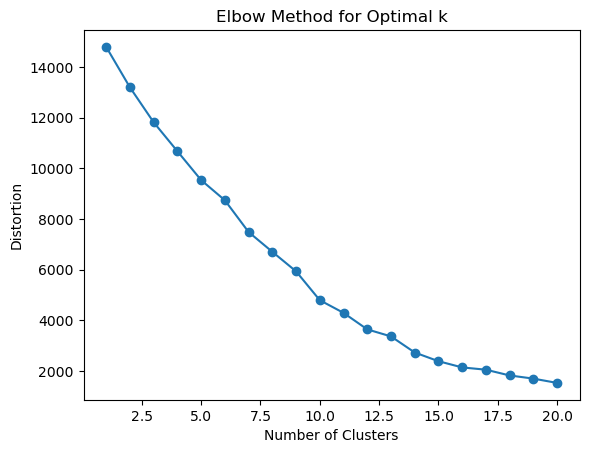

The optimal number of clusters is: 10


In [24]:
# K-MEANS MODEL 1

# Determine the optimal number of clusters using the elbow method
distortions = []
for k in range(1, 21):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numeric_features)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 21), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()

# Use KneeLocator to find the optimal number of clusters
knee_locator = KneeLocator(range(1, 21), distortions, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_k}")




In [25]:
# Choose the optimal number of clusters and fit the model
optimal_k = 10  # Replace with the value from the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_stock_data_filtered['Cluster'] = kmeans.fit_predict(numeric_features)

# Evaluation: User Input Function
To turn this model into a usable program, we create a function that recommends 5 stocks that are most similar to a user-specified stock ticker. The result is based on K-Means Clustering and Euclidean Distance. The function takes in a user input, filters out all stocks except the stocks that are in the same cluster as the input stock, calculates euclidean distance between the input stock and all the other stocks in the cluster, and then returns the top 5 closest stocks by euclidean distance. These 5 stocks returned will be the stocks most similar in value to the user-specified stock. 

In [26]:
def recommend_similar_stocks(stock_symbol, df, scaled_data, num_recommendations=5):
    # Find the index and cluster of the input stock
    stock_index = df[df['Symbol'] == stock_symbol].index[0]
    stock_cluster = df.loc[stock_index, 'Cluster']
    
    # Filter stocks in the same cluster
    cluster_stocks = df[df['Cluster'] == stock_cluster]
    
    # Exclude the input stock
    cluster_stocks = cluster_stocks[cluster_stocks['Symbol'] != stock_symbol]
    
    # Get the feature values of the input stock and the other stocks
    stock_features = scaled_data[stock_index].reshape(1, -1)
    
    # Use the indices from the cluster_stocks dataframe and match them to the scaled_data
    cluster_stocks_reset = cluster_stocks.reset_index(drop=True)
    cluster_features = scaled_data[cluster_stocks_reset.index]
    
    # Calculate Euclidean distance to all other stocks in the same cluster
    distances = euclidean_distances(stock_features, cluster_features).flatten()
    
    # Add the distances as a column to the cluster_stocks dataframe
    cluster_stocks_reset['Distance'] = distances
    
    # Sort by distance (smaller distance means more similar)
    cluster_stocks_reset = cluster_stocks_reset.sort_values(by='Distance')
    
    # Return the top N recommendations
    return cluster_stocks_reset.head(num_recommendations)



In [27]:
# Example usage:

# Make sure to pass the numeric features of the scaled dataframe as scaled_data
recommendations = recommend_similar_stocks("AAPL", df_stock_data_filtered, numeric_features.values)
print(recommendations[['Symbol', 'Cluster', 'Distance']])

    Symbol  Cluster      Distance
0     MSFT        0  2.980232e-08
17      PG        0  5.438515e-01
163   PYPL        0  8.828728e-01
303     EA        0  8.862439e-01
2    GOOGL        0  9.562137e-01


# Evaluation: Cluster Analysis and Distribution
To get a sense of how many clusters we have and how many stocks are in each cluster, we write code that calculates and displays the number of stocks in each cluster. This will help us determine whether the clusters are balanced or imbalanced. 

In [28]:
# Analyze cluster distribution
cluster_counts = df_stock_data_filtered['Cluster'].value_counts()
print("Number of stocks in each cluster:")
print(cluster_counts)


Number of stocks in each cluster:
Cluster
0    1325
6       8
3       4
9       2
2       1
4       1
5       1
8       1
1       1
7       1
Name: count, dtype: int64


# Evaluation: Silhouette Score, Davis-Bouldin Index, Intra-Cluster Similarity, and Inter-Cluster Similarity
In addition to analyzing the distribution of stocks across clusters, we also assess the quality of the clustering model using evaluation metrics. These metrics provide insights into how well the clusters are formed and how distinct they are from one another. Below is a brief explanation of each metric used:
* *Silhouette Score*: The Silhouette Score measures how similar each stock is to its assigned cluster compared to other clusters. It ranges from -1 to 1, where higher values indicate that stocks are well-matched to their own clusters and poorly matched to other clusters.
  
* *Davies-Bouldin Index*: This index evaluates the compactness and separation of the clusters. Lower values indicate better clustering, as it signifies that clusters are more compact and well-separated from each other.
  
* *Intra-Cluster Similarity*: This metric measures the average similarity of stocks within the same cluster. Lower values are better because they indicate that the stocks within a cluster are more similar to one another. High intra-cluster similarity suggests that the clustering algorithm has successfully grouped stocks that are similar to each other based on the features considered. However, excessively low intra-cluster similarity could also indicate that the clusters are too homogeneous, meaning the clustering may not have separated meaningful differences.

* *Inter-Cluster Similarity*: This metric evaluates how dissimilar the clusters are from one another. Higher values are better because they indicate that the clusters are more distinct. High inter-cluster similarity suggests that the clusters are not well-separated and may be blending together, while low inter-cluster similarity suggests clear separation between clusters. Ideally, clusters should have low intra-cluster similarity (to ensure internal coherence) and high inter-cluster similarity (to ensure distinct groups).

In [29]:
# Calculate silhouette score for the clustering
silhouette_avg = silhouette_score(numeric_features, df_stock_data_filtered['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(numeric_features, df_stock_data_filtered['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Silhouette Score: 0.8611319156082192
Davies-Bouldin Index: 0.3256487247619144


In [30]:
# Compute Euclidean distance matrix for all points
distance_matrix = euclidean_distances(numeric_features)

# Reset index to ensure consistency
df_stock_data_filtered = df_stock_data_filtered.reset_index(drop=True)

# Get unique cluster labels
clusters = df_stock_data_filtered['Cluster'].unique()

# Compute intra-cluster similarity (lower values are better)
intra_cluster_similarities = {}
cluster_sizes = df_stock_data_filtered['Cluster'].value_counts().to_dict()  # Get cluster sizes

for cluster in clusters:
    indices = df_stock_data_filtered[df_stock_data_filtered['Cluster'] == cluster].index.to_numpy()
    if len(indices) > 1:  # Avoid single-element clusters
        intra_cluster_similarities[cluster] = np.mean(distance_matrix[np.ix_(indices, indices)])


# Compute weighted average intra-cluster similarity
weighted_sum = sum(cluster_sizes[c] * intra_cluster_similarities[c] for c in intra_cluster_similarities)
total_samples = sum(cluster_sizes.values())

overall_intra_cluster_similarity = weighted_sum / total_samples



In [31]:
# Print intra-cluster similarities
print("Intra-Cluster Similarities (Lower is better):")
for cluster, similarity in intra_cluster_similarities.items():
    print(f"Cluster {cluster}: {similarity:.4f}")

# Print overall intra-cluster similarity
print(f"\nOverall Intra-Cluster Similarity (Lower is better): {overall_intra_cluster_similarity:.4f}")

Intra-Cluster Similarities (Lower is better):
Cluster 0: 1.4723
Cluster 3: 7.6170
Cluster 6: 3.7980
Cluster 9: 6.4289

Overall Intra-Cluster Similarity (Lower is better): 1.5052


In [32]:
# Inter-Cluster Dissimilarity
# Compute the Euclidean distance between cluster centroids
centroids = kmeans.cluster_centers_  # Get the cluster centroids
inter_cluster_distances = euclidean_distances(centroids)

# Compute the average distance between centroids
avg_inter_cluster_distance = np.mean(inter_cluster_distances)


In [33]:
print(f"\nAverage Inter-Cluster Distance (Higher is better): {avg_inter_cluster_distance:.4f}")


Average Inter-Cluster Distance (Higher is better): 34.4608


# Evaluation: Model 1 Metrics, Distribution, and Interpretation
* Cluster Distribution
* * The cluster distribution is highly imbalanced. Cluster 0 has 1325 stocks and the remaining clusters have less than 8 stocks each

* Metrics
* * Silhouette Score: 0.861 (very high, indicating strong cluster separation and cohesion).
  * Davies-Bouldin Index: 0.325 (excellent; lower values indicate better clustering quality).
  * Overall Intra-Cluster Similarity: 1.5052
  * Average Inter-Cluster Distance: 34.4608 (Very high, but misleading because of weak distribution)

* Interpretation
* * While our metrics are excellent, it is slightly misleading since the highly imbalanced cluster distribution makes the model meaningless and unuseful, as it is unable to distinguish groups in the dataset. 

# Data Preparation: Yeo-Johnson Transformation
In the initial version of the model (Model 1), the clustering resulted in a highly imbalanced distribution, with the vast majority of stocks falling into a single cluster. This indicated that the model struggled to differentiate between stocks based on the given features, suggesting that the data required further processing.
To address this issue, I applied the *Yeo-Johnson transformation*, which is a statistical technique used to normalize data. By reducing skewness and bringing the data closer to a normal distribution, this transformation helps the model better identify patterns and distinctions within the dataset.

In [34]:
# Apply Yeo-Johnson transformation to the numeric_features dataframe
pt = PowerTransformer(method='yeo-johnson')

# Transform the numeric_features columns
numeric_features_transformed = pd.DataFrame(pt.fit_transform(numeric_features), columns=numeric_features.columns)

# Apply the same transformation to the df_stock_data_filtered dataframe
# Assuming df_filtered_stocks_scaled contains the same numeric features (same columns) as numeric_features
df_stock_data_transformed = df_stock_data_filtered.copy()

# Apply the transformation to the numeric columns in df_stock_data_filtered
df_stock_data_transformed[numeric_features.columns] = pt.transform(df_stock_data_filtered[numeric_features.columns])

# Verify the transformation by checking the first few rows
print(df_stock_data_transformed.head())


  Symbol                                Name    Market Cap  \
0   AAPL             Apple Inc. Common Stock  3.288959e+12   
1   MSFT  Microsoft Corporation Common Stock  3.206167e+12   
2   NVDA     NVIDIA Corporation Common Stock  2.864613e+12   
3  GOOGL  Alphabet Inc. Class A Common Stock  1.945719e+12   
4   AMZN        Amazon.com Inc. Common Stock  1.940525e+12   

   Trailing P/E Ratio  Forward P/E Ratio  Price to Book Ratio  \
0            0.799788           0.141966             2.213650   
1            0.685802           0.162581             1.438932   
2            1.343524           0.218069             2.222374   
3            0.121466           0.009075             0.979758   
4            1.179247           0.349015             1.213726   

   Earnings Per Share Forward  Return on Equity  Debt to Equity Ratio  \
0                    0.689405          1.990881              1.352496   
1                    1.393749          0.294683             -0.805363   
2                

# Modeling: Model 2 
### K-Means Clustering with Yeo-Johnson Transformed Data


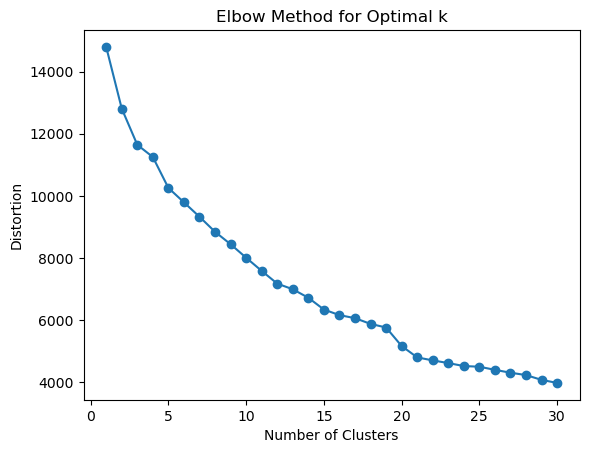

The optimal number of clusters is: 15


In [35]:
# KMEANS MODEL 2

# Determine the optimal number of clusters using the elbow method
distortions = []
for k in range(1, 31):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numeric_features_transformed)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 31), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()

# Use KneeLocator to find the optimal number of clusters
knee_locator = KneeLocator(range(1, 31), distortions, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_k}")




In [36]:
# Choose the optimal number of clusters and fit the model
optimal_k = 15  # Replace with the value from the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_stock_data_transformed['Cluster'] = kmeans.fit_predict(numeric_features_transformed)

In [37]:
# Example usage:
# Make sure to pass the numeric features of the scaled dataframe as scaled_data
recommendations = recommend_similar_stocks("AAPL", df_stock_data_transformed, numeric_features_transformed.values)
print(recommendations[['Symbol', 'Cluster', 'Distance']])

    Symbol  Cluster  Distance
0      LLY       14  0.000000
16     HON       14  0.923269
94     LNW       14  1.531655
17     NKE       14  1.677365
123   FTDR       14  1.933407


In [38]:
# Analyze cluster distribution
cluster_counts = df_stock_data_transformed['Cluster'].value_counts()
print("Number of stocks in each cluster:")
print(cluster_counts)


Number of stocks in each cluster:
Cluster
2     270
13    214
4     161
6     152
7     142
14    138
12    113
0      75
9      41
3      16
10     10
8       6
1       5
11      1
5       1
Name: count, dtype: int64


In [39]:
# Calculate silhouette score for the clustering
silhouette_avg = silhouette_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Silhouette Score: 0.14456961751857364
Davies-Bouldin Index: 1.2254774056077409


In [40]:
# Compute Euclidean distance matrix for all points
distance_matrix = euclidean_distances(numeric_features_transformed)

# Reset index to ensure consistency
df_stock_data_transformed = df_stock_data_transformed.reset_index(drop=True)

# Get unique cluster labels
clusters = df_stock_data_transformed['Cluster'].unique()

# Compute intra-cluster similarity (lower values are better)
intra_cluster_similarities = {}
cluster_sizes = df_stock_data_transformed['Cluster'].value_counts().to_dict()  # Get cluster sizes

for cluster in clusters:
    indices = df_stock_data_transformed[df_stock_data_transformed['Cluster'] == cluster].index.to_numpy()
    if len(indices) > 1:  # Avoid single-element clusters
        intra_cluster_similarities[cluster] = np.mean(distance_matrix[np.ix_(indices, indices)])



# Compute weighted average intra-cluster similarity
weighted_sum = sum(cluster_sizes[c] * intra_cluster_similarities[c] for c in intra_cluster_similarities)
total_samples = sum(cluster_sizes.values())

overall_intra_cluster_similarity = weighted_sum / total_samples



In [41]:
# Print intra-cluster similarities
print("Intra-Cluster Similarities (Lower is better):")
for cluster, similarity in intra_cluster_similarities.items():
    print(f"Cluster {cluster}: {similarity:.4f}")

# Print overall intra-cluster similarity
print(f"\nOverall Intra-Cluster Similarity (Lower is better): {overall_intra_cluster_similarity:.4f}")

Intra-Cluster Similarities (Lower is better):
Cluster 14: 2.6673
Cluster 4: 2.2893
Cluster 12: 3.4798
Cluster 7: 2.4909
Cluster 6: 2.4274
Cluster 13: 2.3928
Cluster 1: 5.1081
Cluster 0: 2.5764
Cluster 2: 2.1921
Cluster 10: 5.3301
Cluster 8: 4.2269
Cluster 9: 4.3365
Cluster 3: 3.6758

Overall Intra-Cluster Similarity (Lower is better): 2.5952


In [42]:
# Inter-Cluster Dissimilarity
# Compute the Euclidean distance between cluster centroids
centroids = kmeans.cluster_centers_  # Get the cluster centroids
inter_cluster_distances = euclidean_distances(centroids)

# Compute the average distance between centroids
avg_inter_cluster_distance = np.mean(inter_cluster_distances)


In [43]:
print(f"\nAverage Inter-Cluster Distance (Higher is better): {avg_inter_cluster_distance:.4f}")


Average Inter-Cluster Distance (Higher is better): 10.4033


# Evaluation: Model 2
* Cluster Distribution
* * Better cluster distribution than Model 1, but still not great with cluster 2 having 270 stocks and cluster 5 heaving 1 stock. This is a step in the right direction, though. 

* Metrics
* * Silhouette Score: 0.144 (low; indicates poor cluster separation or overlap between clusters).
  * Davies-Bouldin Index: 1.225 (high; worse clustering quality).
  * Overall Intra-Cluster Similarity: 2.1857
  * Average Inter-Cluster Distance: 10.4033 (Much lower, indicating poor separation between clusters)

* Interpretation
* * Although the cluster distribution got much better, which was the goal of this transformation, the metrics became very poor. 

# Modeling: Model 3 
### K-Means Clustering with Yeo-Johnson Transformed Data and kmeans parameter 'init='k-means++'
To further improve the model, we're going to try implimenting "init='k-means++'". The `init='k-means++'` parameter in the K-Means algorithm is used to improve the initialization of cluster centroids. In traditional K-Means, centroids are randomly selected at the start, which can sometimes lead to poor clustering results or longer convergence times.
With `k-means++`, centroids are chosen in a way that ensures they are spread out across the dataset, reducing the chances of suboptimal clusters. By including this parameter, the goal is to achieve more robust and reliable clustering results for the stocks in the dataset.

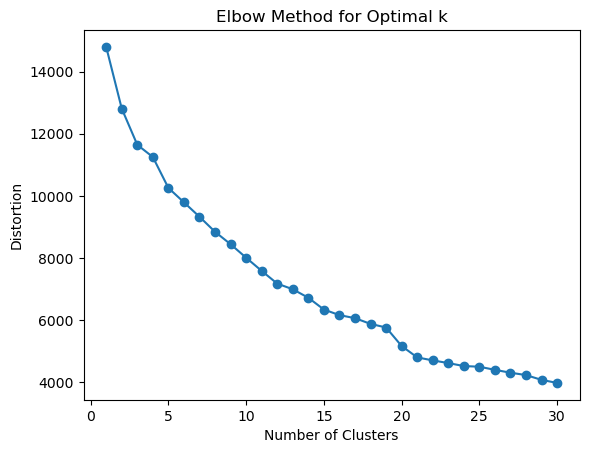

The optimal number of clusters is: 15


In [44]:
# KMEANS MODEL 3
# Determine the optimal number of clusters using the elbow method
distortions = []
for k in range(1, 31):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(numeric_features_transformed)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 31), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()

# Use KneeLocator to find the optimal number of clusters
knee_locator = KneeLocator(range(1, 31), distortions, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_k}")




In [45]:
# Choose the optimal number of clusters and fit the model
optimal_k = 15  # Replace with the value from the elbow method
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
df_stock_data_transformed['Cluster'] = kmeans.fit_predict(numeric_features_transformed)

In [46]:
# Example usage:
# Make sure to pass the numeric features of the scaled dataframe as scaled_data
recommendations = recommend_similar_stocks("AAPL", df_stock_data_transformed, numeric_features_transformed.values)
print(recommendations[['Symbol', 'Cluster', 'Distance']])

   Symbol  Cluster  Distance
0    ORCL       21  0.000000
16    MSI       21  0.923269
17    DEO       21  1.677365
22    RCL       21  2.095646
53   FTDR       21  2.244524


In [47]:
# Analyze cluster distribution
cluster_counts = df_stock_data_transformed['Cluster'].value_counts()
print("Number of stocks in each cluster:")
print(cluster_counts)


Number of stocks in each cluster:
Cluster
29    125
18    118
22    118
19    107
16     94
20     94
25     93
23     85
4      77
6      69
21     60
2      54
1      50
0      47
24     28
9      23
17     19
26     18
5      17
3      15
12      7
14      6
7       6
13      5
28      3
10      3
27      1
8       1
11      1
15      1
Name: count, dtype: int64


In [48]:
# Calculate silhouette score for the clustering
silhouette_avg = silhouette_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Silhouette Score: 0.13168605809930622
Davies-Bouldin Index: 1.2342274576313434


In [49]:
# Compute Euclidean distance matrix for all points
distance_matrix = euclidean_distances(numeric_features_transformed)

# Reset index to ensure consistency
df_stock_data_transformed = df_stock_data_transformed.reset_index(drop=True)

# Get unique cluster labels
clusters = df_stock_data_transformed['Cluster'].unique()

# Compute intra-cluster similarity (lower values are better)
intra_cluster_similarities = {}
cluster_sizes = df_stock_data_transformed['Cluster'].value_counts().to_dict()  # Get cluster sizes

for cluster in clusters:
    indices = df_stock_data_transformed[df_stock_data_transformed['Cluster'] == cluster].index.to_numpy()
    if len(indices) > 1:  # Avoid single-element clusters
        intra_cluster_similarities[cluster] = np.mean(distance_matrix[np.ix_(indices, indices)])



# Compute weighted average intra-cluster similarity
weighted_sum = sum(cluster_sizes[c] * intra_cluster_similarities[c] for c in intra_cluster_similarities)
total_samples = sum(cluster_sizes.values())

overall_intra_cluster_similarity = weighted_sum / total_samples



In [50]:
# Inter-Cluster Dissimilarity
# Compute the Euclidean distance between cluster centroids
centroids = kmeans.cluster_centers_  # Get the cluster centroids
inter_cluster_distances = euclidean_distances(centroids)

# Compute the average distance between centroids
avg_inter_cluster_distance = np.mean(inter_cluster_distances)


In [51]:
# Print intra-cluster similarities
print("Intra-Cluster Similarities (Lower is better):")
for cluster, similarity in intra_cluster_similarities.items():
    print(f"Cluster {cluster}: {similarity:.4f}")

# Print overall intra-cluster similarity
print(f"\nOverall Intra-Cluster Similarity (Lower is better): {overall_intra_cluster_similarity:.4f}")

Intra-Cluster Similarities (Lower is better):
Cluster 21: 2.3353
Cluster 1: 2.6745
Cluster 19: 1.8987
Cluster 16: 2.1147
Cluster 5: 2.5904
Cluster 23: 2.1793
Cluster 18: 1.5760
Cluster 20: 2.1284
Cluster 25: 1.9200
Cluster 13: 5.1081
Cluster 4: 2.1882
Cluster 6: 2.2833
Cluster 0: 2.1217
Cluster 22: 1.9089
Cluster 29: 2.0545
Cluster 14: 3.6819
Cluster 2: 2.2464
Cluster 12: 3.4526
Cluster 24: 3.1230
Cluster 9: 3.3937
Cluster 7: 4.2269
Cluster 26: 2.6008
Cluster 28: 3.5759
Cluster 17: 3.3422
Cluster 3: 2.7764
Cluster 10: 5.2083

Overall Intra-Cluster Similarity (Lower is better): 2.1857


In [52]:
print(f"\nAverage Inter-Cluster Distance (Higher is better): {avg_inter_cluster_distance:.4f}")


Average Inter-Cluster Distance (Higher is better): 10.2694


# Evaluation: Model 3
* Cluster Distribution
* * Much better cluster distribution and large number of clusters. However, 10 of those clusters have 7 or less stocks each. 

* Metrics
* * Silhouette Score: 0.132 (low; indicates poor separation).
  * Davies-Bouldin Index: 1.23 (better than Model 2 but still suboptimal).
  * Intra-Cluster Similarity: 2.1857
  * Average Inter-Cluster Distance: 10.2694 (Similar to Model 2, indicating poor separation)

* Interpretation
* * The cluster sizes have better balances, but theres a bit too many clusters with a few amount of stocks and the metrics are still suboptimal. 

# Moodeling: Model 4
### K-Means Clustering with Yeo-Johnson Transformed Data and kmeans parameter 'max_iter=500'
The `max_iter` parameter in K-Means determines the maximum number of iterations the algorithm will run to update the cluster centroids. By default, it is set to 300. Increasing `max_iter` to 500 allows the algorithm more iterations to converge, especially for datasets where the clustering process may take longer due to complex or overlapping data patterns. The reason for trying this adjustment is to ensure that the model has enough iterations to find stable and well-separated clusters, preventing premature termination before convergence is achieved. This will also increase the amount of time the model takes to run.

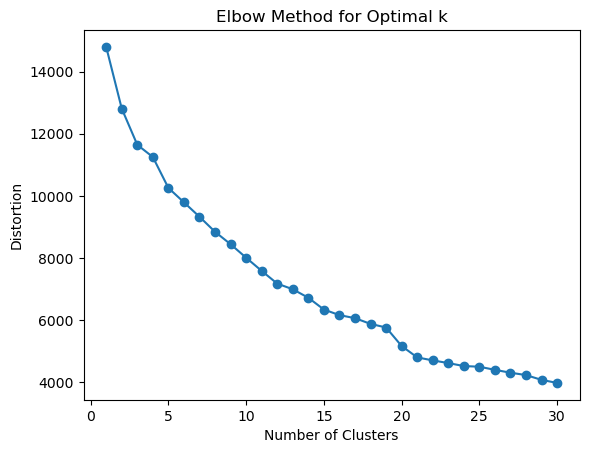

The optimal number of clusters is: 15


In [53]:
# KMEANS MODEL 4
# Determine the optimal number of clusters using the elbow method
distortions = []
for k in range(1, 31):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42)
    kmeans.fit(numeric_features_transformed)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 31), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()

# Use KneeLocator to find the optimal number of clusters
knee_locator = KneeLocator(range(1, 31), distortions, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_k}")




In [54]:
# Choose the optimal number of clusters and fit the model
optimal_k = 15  # Replace with the value from the elbow method
kmeans = KMeans(n_clusters=optimal_k, max_iter=500, random_state=42)
df_stock_data_transformed['Cluster'] = kmeans.fit_predict(numeric_features_transformed)

In [55]:
# Example usage:
# Make sure to pass the numeric features of the scaled dataframe as scaled_data
recommendations = recommend_similar_stocks("AAPL", df_stock_data_transformed, numeric_features_transformed.values)
print(recommendations[['Symbol', 'Cluster', 'Distance']])

    Symbol  Cluster  Distance
0      LLY       14  0.000000
16     HON       14  0.923269
94     LNW       14  1.531655
17     NKE       14  1.677365
123   FTDR       14  1.933407


In [56]:
# Analyze cluster distribution
cluster_counts = df_stock_data_transformed['Cluster'].value_counts()
print("Number of stocks in each cluster:")
print(cluster_counts)


Number of stocks in each cluster:
Cluster
2     270
13    214
4     161
6     152
7     142
14    138
12    113
0      75
9      41
3      16
10     10
8       6
1       5
11      1
5       1
Name: count, dtype: int64


In [57]:
# Calculate silhouette score for the clustering
silhouette_avg = silhouette_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Silhouette Score: 0.14456961751857364
Davies-Bouldin Index: 1.2254774056077409


In [58]:
# Compute Euclidean distance matrix for all points
distance_matrix = euclidean_distances(numeric_features_transformed)

# Reset index to ensure consistency
df_stock_data_transformed = df_stock_data_transformed.reset_index(drop=True)

# Get unique cluster labels
clusters = df_stock_data_transformed['Cluster'].unique()

# Compute intra-cluster similarity (lower values are better)
intra_cluster_similarities = {}
cluster_sizes = df_stock_data_transformed['Cluster'].value_counts().to_dict()  # Get cluster sizes

for cluster in clusters:
    indices = df_stock_data_transformed[df_stock_data_transformed['Cluster'] == cluster].index.to_numpy()
    if len(indices) > 1:  # Avoid single-element clusters
        intra_cluster_similarities[cluster] = np.mean(distance_matrix[np.ix_(indices, indices)])



# Compute weighted average intra-cluster similarity
weighted_sum = sum(cluster_sizes[c] * intra_cluster_similarities[c] for c in intra_cluster_similarities)
total_samples = sum(cluster_sizes.values())

overall_intra_cluster_similarity = weighted_sum / total_samples



In [59]:
# Inter-Cluster Dissimilarity
# Compute the Euclidean distance between cluster centroids
centroids = kmeans.cluster_centers_  # Get the cluster centroids
inter_cluster_distances = euclidean_distances(centroids)

# Compute the average distance between centroids
avg_inter_cluster_distance = np.mean(inter_cluster_distances)


In [60]:
# Print intra-cluster similarities
print("Intra-Cluster Similarities (Lower is better):")
for cluster, similarity in intra_cluster_similarities.items():
    print(f"Cluster {cluster}: {similarity:.4f}")

# Print overall intra-cluster similarity
print(f"\nOverall Intra-Cluster Similarity (Lower is better): {overall_intra_cluster_similarity:.4f}")

Intra-Cluster Similarities (Lower is better):
Cluster 14: 2.6673
Cluster 4: 2.2893
Cluster 12: 3.4798
Cluster 7: 2.4909
Cluster 6: 2.4274
Cluster 13: 2.3928
Cluster 1: 5.1081
Cluster 0: 2.5764
Cluster 2: 2.1921
Cluster 10: 5.3301
Cluster 8: 4.2269
Cluster 9: 4.3365
Cluster 3: 3.6758

Overall Intra-Cluster Similarity (Lower is better): 2.5952


In [61]:
print(f"\nAverage Inter-Cluster Distance (Higher is better): {avg_inter_cluster_distance:.4f}")


Average Inter-Cluster Distance (Higher is better): 10.4033


# Evaluation: Model 4
* Cluster Distribution
* * Good balance and number of clusters, with only 4 of those clusters being 6 stocks or less. 

* Metrics
* * Silhouette Score: 0.145 (low; indicates poor separation).
  * Davies-Bouldin Index: 1.23 (better than Models 2 and 3)
  * Intra-Cluster Similarity: 2.5952
  * Average Inter-Cluster Distance: 10.4033 (Same as model 2, poor separation between clusters)
    
* Interpretation
* * This model is has moderately balanced clusters and although the metrics are still poor, they have gotten better. 

# Modeling: Model 5
### K-Means Clustering with Yeo-Johnson Transformed Data and kmeans parameter 'n_init=20'
The `n_init` parameter in K-Means specifies the number of times the algorithm will run with different centroid initializations. By default, `n_init` is typically set to 10. Increasing it to 20 ensures the algorithm runs more iterations with varied starting points for centroids. The reason for making this change is to improve the chances of finding the global optimal clustering solution, especially for datasets with complex structures. Each run with a new initialization helps avoid suboptimal solutions caused by poor initial centroid placement. By increasing `n_init` to 20, the model is more likely to achieve better clustering performance and stability.

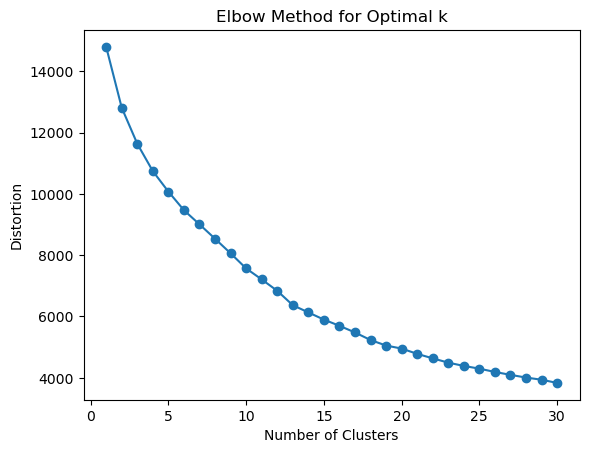

The optimal number of clusters is: 13


In [62]:
# kmeans model 5
# Determine the optimal number of clusters using the elbow method
distortions = []
for k in range(1, 31):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeans.fit(numeric_features_transformed)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 31), distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()

# Use KneeLocator to find the optimal number of clusters
knee_locator = KneeLocator(range(1, 31), distortions, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_k}")




In [63]:
# Choose the optimal number of clusters and fit the model
optimal_k = 13  # Replace with the value from the elbow method
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
df_stock_data_transformed['Cluster'] = kmeans.fit_predict(numeric_features_transformed)

In [64]:
# Example usage:
# Make sure to pass the numeric features of the scaled dataframe as scaled_data
recommendations = recommend_similar_stocks("AAPL", df_stock_data_transformed, numeric_features_transformed.values)
print(recommendations[['Symbol', 'Cluster', 'Distance']])

   Symbol  Cluster  Distance
0    ORCL        1  0.000000
16     WM        1  0.923269
17    AON        1  1.677365
22    ECL        1  2.095646
53    AVY        1  2.244524


In [65]:
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)


In [66]:
# Get the rows in the original dataframe that match the recommendations
recommended_rows = df_stock_data_transformed[
    df_stock_data_transformed['Symbol'].isin(recommendations['Symbol'])
]

# Print out the rows for comparison
print("Recommended Stocks Comparison:")
recommended_rows


Recommended Stocks Comparison:


,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Operating Margin,Price to Sales Ratio,Quick Ratio,Enterprise Value to EBITDA,Free Cash Flow Yield,Trailing P/E Ratio Category,Forward P/E Ratio Category,Price to Book Ratio Category,Earnings Per Share Forward Category,Return on Equity Category,Debt to Equity Ratio Category,Operating Margin Category,Price to Sales Ratio Category,Quick Ratio Category,Enterprise Value to EBITDA Category,Free Cash Flow Yield Category,Cluster
16,ORCL,Oracle Corporation Common Stock,4.719790e+11,0.863980,0.032160,2.202149,0.510817,1.964914,2.199384,0.404717,1.025530,-0.807185,0.041994,-0.068386,Overvalued,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,1
136,WM,Waste Management Inc. Common Stock,8.360190e+10,0.524266,0.109285,1.393461,0.654037,0.286793,1.351599,0.130480,0.037118,-0.495559,0.009359,-0.099841,Overvalued,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,1
155,AON,Aon plc Class A Ordinary Shares (Ireland),7.618465e+10,0.466385,-0.009881,1.581742,1.564825,0.935710,1.635372,0.106477,0.372663,-1.469850,0.027643,0.054826,Overvalued,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Fair Value,1
167,ECL,Ecolab Inc. Common Stock,7.204492e+10,0.577379,0.237459,1.334366,0.566092,0.152757,0.439289,-0.007090,0.119789,-0.301925,0.023075,0.024071,Overvalued,Overvalued,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,Overvalued,Undervalued,1
535,AVY,Avery Dennison Corporation Common Stock,1.779793e+10,-0.098919,-0.075727,0.741037,0.975607,0.221683,0.769032,-0.055196,-0.598112,-0.886935,0.001267,0.092379,Overvalued,Fair Value,Overvalued,Overvalued,Undervalued,Overvalued,Undervalued,Fair Value,Undervalued,Overvalued,Fair Value,1


In [67]:
# Analyze cluster distribution
cluster_counts = df_stock_data_transformed['Cluster'].value_counts()
print("Number of stocks in each cluster:")
print(cluster_counts)


Number of stocks in each cluster:
Cluster
2     186
19    145
9     129
28     97
1      86
8      86
20     86
0      80
6      67
27     60
7      56
4      51
21     47
29     43
3      25
15     21
5      19
17     15
24     11
13      8
25      6
16      6
11      6
22      3
23      1
18      1
10      1
14      1
26      1
12      1
Name: count, dtype: int64


In [68]:
# Calculate silhouette score for the clustering
silhouette_avg = silhouette_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(numeric_features_transformed, df_stock_data_transformed['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Silhouette Score: 0.1501598777922055
Davies-Bouldin Index: 1.1225946625048984


In [69]:
# Compute Euclidean distance matrix for all points
distance_matrix = euclidean_distances(numeric_features_transformed)

# Reset index to ensure consistency
df_stock_data_transformed = df_stock_data_transformed.reset_index(drop=True)

# Get unique cluster labels
clusters = df_stock_data_transformed['Cluster'].unique()

# Compute intra-cluster similarity (lower values are better)
intra_cluster_similarities = {}
cluster_sizes = df_stock_data_transformed['Cluster'].value_counts().to_dict()  # Get cluster sizes

for cluster in clusters:
    indices = df_stock_data_transformed[df_stock_data_transformed['Cluster'] == cluster].index.to_numpy()
    if len(indices) > 1:  # Avoid single-element clusters
        intra_cluster_similarities[cluster] = np.mean(distance_matrix[np.ix_(indices, indices)])


# Compute weighted average intra-cluster similarity
weighted_sum = sum(cluster_sizes[c] * intra_cluster_similarities[c] for c in intra_cluster_similarities)
total_samples = sum(cluster_sizes.values())

overall_intra_cluster_similarity = weighted_sum / total_samples



In [70]:
# Inter-Cluster Dissimilarity
# Compute the Euclidean distance between cluster centroids
centroids = kmeans.cluster_centers_  # Get the cluster centroids
inter_cluster_distances = euclidean_distances(centroids)

# Compute the average distance between centroids
avg_inter_cluster_distance = np.mean(inter_cluster_distances)


In [71]:
# Print intra-cluster similarities
print("Intra-Cluster Similarities (Lower is better):")
for cluster, similarity in intra_cluster_similarities.items():
    print(f"Cluster {cluster}: {similarity:.4f}")

# Print overall intra-cluster similarity
print(f"\nOverall Intra-Cluster Similarity (Lower is better): {overall_intra_cluster_similarity:.4f}")

Intra-Cluster Similarities (Lower is better):
Cluster 1: 2.3296
Cluster 4: 2.7218
Cluster 7: 2.4675
Cluster 8: 1.8907
Cluster 28: 2.0527
Cluster 20: 2.0562
Cluster 3: 3.3262
Cluster 6: 2.0452
Cluster 2: 1.9711
Cluster 19: 1.9501
Cluster 25: 3.3484
Cluster 0: 1.9968
Cluster 27: 2.1023
Cluster 9: 1.9817
Cluster 29: 2.1222
Cluster 21: 2.3250
Cluster 11: 4.8762
Cluster 24: 2.9328
Cluster 13: 3.5449
Cluster 16: 4.2269
Cluster 15: 2.6506
Cluster 22: 3.5759
Cluster 5: 3.3422
Cluster 17: 2.7764

Overall Intra-Cluster Similarity (Lower is better): 2.1817


In [72]:
print(f"\nAverage Inter-Cluster Distance (Higher is better): {avg_inter_cluster_distance:.4f}")


Average Inter-Cluster Distance (Higher is better): 11.2299


# Evaluation: Model 5
* Cluster Distribution
* * Although this model has a large amount of clusters, they are very reasonably balanced with the highest only having 186. However, there are a good amount of clusters with only one stock.  

* Metrics
* * Silhouette Score: 0.15 (better than Models 2, 3, and 4 but far below Model 1).
  * Davies-Bouldin Index: 1.12 (best among all models; indicates good clustering quality).
  * Intra-Cluster Similarity: 2.1817
  * Average Inter-Cluster Distance: 11.2299 (Better than models 2, 3, and 4)
    
* Interpretation
* * This model has relativley good metrics, much better than model 2, 3, and 4 and almost as good as Model 1. On top of this, the cluster distribution is much more balanced. 

# Evaluation: Best and Final Model
### Model 5
Even though Model 1 technically has the best metrics, it is impractical because of it's extremely imbalanced distribution. Model 5 strikes the best balance between metrics and cluster distribution. 
* It has the best Davies-Bouldin Index (1.12), indicating good clustering quality.
* Its Silhouette Score (0.15) is better than Models 2, 3, and 4.
* The Average Inter-Cluster Distancee (11.2299) is better than Models 2, 3, and 4.
* Cluster distribution is reasonably balanced, with fewer extreme outliers compared to Models 2 and 3.
Model 5 has acceptable clustering metrics and practical, interpretable cluster distribution. It provides meaningful segmentation while avoiding the pitfalls of extreme imbalances or poor clustering quality. 

# Modeling: Model 5 Cluster Processing
In the best model for our recommendation system (Model 5), some clusters contained fewer than 15 stocks, which would cause problems for people looking for a solid group of recommended stocks that happen to be from those clusters. To address this, I took the following approach:
* Identify small clusters with less than 15 stocks.
* Instead of removing those outliers, we are going to move them to their closest centroid. By this, I mean the stocks will be moved to a group with more than 15 stocks, to which they are closest in similarity. This will improve the quality of clustering and ensure each cluster has a substantial amount of stocks. 
* For each of the stocks in those small clusters, calculate the Euclidean distance to all centroids (excluding the current small centroid they are in) and move the stock to the centroid with the smallest distance that has more than 15 stocks.
* After reassigning the stocks, we remove the small clusters entirely and reassess overall cluster distribution. 

In [73]:
# Get cluster sizes
cluster_counts = df_stock_data_transformed['Cluster'].value_counts()

# Identify clusters with fewer than 15 stocks
small_clusters = cluster_counts[cluster_counts < 15].index

# Filter stocks belonging to small clusters
stocks_in_small_clusters = df_stock_data_transformed[
    df_stock_data_transformed['Cluster'].isin(small_clusters)
]

# Get centroids from the previously fitted KMeans model
centroids = kmeans.cluster_centers_

# Iterate over each stock in small clusters
for index, stock in stocks_in_small_clusters.iterrows():
    # Get the stock's features
    stock_features = numeric_features_transformed.loc[index].values.reshape(1, -1)
    
    # Calculate distances to all centroids
    distances = euclidean_distances(stock_features, centroids).flatten()
    
    # Exclude the stock's current (small) cluster
    current_cluster = stock['Cluster']
    distances[current_cluster] = np.inf
    
    # Find the nearest cluster with at least 15 stocks
    valid_clusters = [c for c in range(len(centroids)) if c not in small_clusters]
    nearest_cluster = min(valid_clusters, key=lambda c: distances[c])
    
    # Reassign the stock to the new cluster
    df_stock_data_transformed.at[index, 'Cluster'] = nearest_cluster

# Remove the small clusters entirely
df_stock_data_transformed = df_stock_data_transformed[
    ~df_stock_data_transformed['Cluster'].isin(small_clusters)
]

# Recalculate cluster sizes
new_cluster_counts = df_stock_data_transformed['Cluster'].value_counts()

print("Updated distribution of clusters:")
print(new_cluster_counts)


Updated distribution of clusters:
Cluster
2     195
19    147
9     132
28     97
1      92
20     90
8      86
0      83
6      67
27     60
7      57
4      52
21     47
29     43
3      32
5      26
15     24
17     15
Name: count, dtype: int64


# Evaluation: Model 5 Feature Importance
In clustering, understanding the importance of features can help interpret the results and validate the model's effectiveness. By calculating the variance of features across cluster centroids, we identify which features contribute the most to differeentiating clusters. This provides insights into the key drivers of clustering and helps focus on the most impactful features, improving interpretability, and guiding further analysis or decision making. 

In [74]:
# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Convert to a DataFrame for easier analysis
centroids_df = pd.DataFrame(centroids, columns=numeric_features_transformed.columns)

# Calculate the variance across centroids for each feature
feature_variance = centroids_df.var(axis=0)

# Sort features by variance (larger variance indicates higher importance)
sorted_feature_variance = feature_variance.sort_values(ascending=False)

# Output the feature importance based on centroid variance
print("Feature Importance based on centroid variance:")
print(sorted_feature_variance)


Feature Importance based on centroid variance:
Enterprise Value to EBITDA    43.774380
Free Cash Flow Yield          24.768910
Return on Equity              14.885303
Operating Margin               8.295395
Forward P/E Ratio              6.415423
Price to Sales Ratio           1.255582
Price to Book Ratio            1.105507
Trailing P/E Ratio             0.982385
Quick Ratio                    0.953743
Earnings Per Share Forward     0.934981
Debt to Equity Ratio           0.919807
dtype: float64


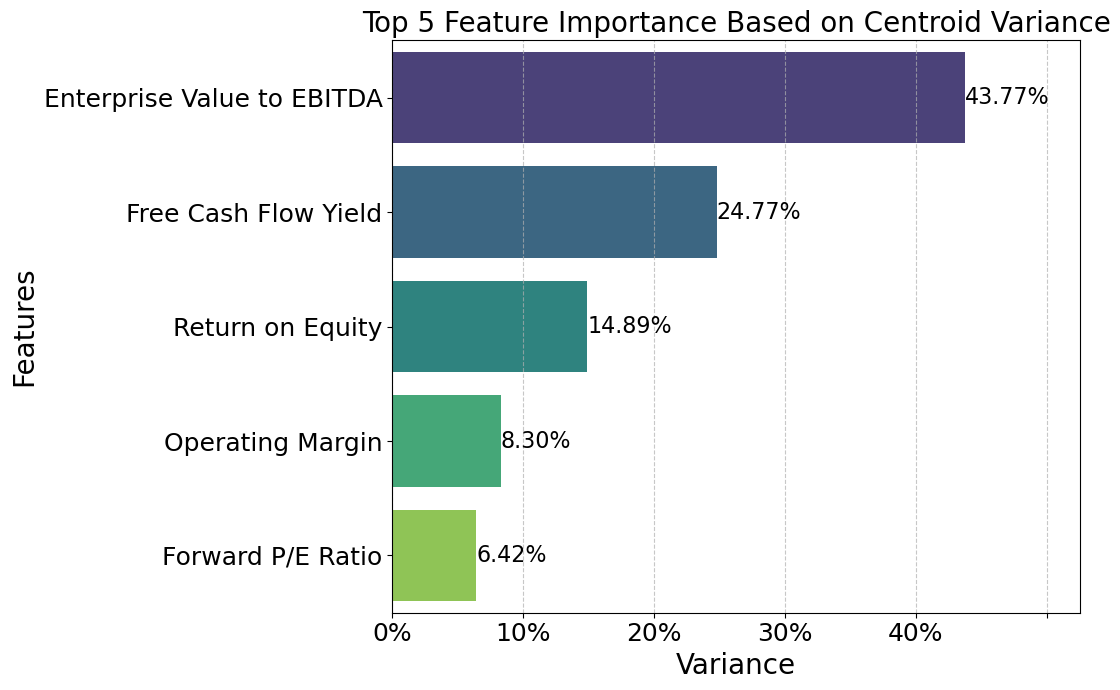

In [75]:
# Select the top 5 features with the highest variance
top_5_features = sorted_feature_variance.head(5)

# Create a bar plot for the top 5 features
plt.figure(figsize=(11, 7))
ax = sns.barplot(
    x=top_5_features.values,
    y=top_5_features.index,
    palette="viridis"
)

# Add titles and labels
plt.title("Top 5 Feature Importance Based on Centroid Variance", fontsize=20)
plt.xlabel("Variance", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Control font size of x and y ticks
plt.tick_params(axis='x', labelsize=18)  # Set font size for x-axis ticks
plt.tick_params(axis='y', labelsize=18)  # Set font size for y-axis ticks

# Add the values to the right of the bars
for i, value in enumerate(top_5_features.values):
    ax.text(value, i, f'{value:.2f}%', va='center', ha='left', fontsize=16)
    
# Format the y-axis ticks with the "%" sign
ax.set_xticklabels([f'{label*10}%' for label in ax.get_yticks()])

# Adjust the x-axis length by setting the xlim
plt.xlim(0, top_5_features.values.max() * 1.2)  # 10% more than the max value for extra space

# Show the plot
plt.tight_layout()
plt.show()


# Conclusion
To wrap up this analysis, we'll end by giving a summary of the process we used to build and refine our model, the limitatios of our data, and future actions to improve our model. 

# Process Summary
* Pulled the top 2,000 stocks by market cap from NASDAQ
* Remove any stocks that aren't common shares
* Remove rows with too much missing data and use median imputation on the remaining rows with enough information to run analysis on.
* Scale data in order to prepare for modeling
* Run our data through K-Means Clustering, evaluate the distribution and metric results
* Process data, tune model parameters, then choose the best final model.

# Limitations
* While Yahoo Finance data is free, it is limited. Certain financial valuation parameters are not available and there's no verification on how up to date it is.
* Value investors judge the value of a company using different parameters, not just these exact 11 parameters used in this model. In order to get a more accurate model for a company or investor, the model would have to be curated using the exact parameters they look at and the exact ranges by which they judge if the stock is overvalued, undervalued, or fair valued.
* The cluster distributions are not segmented into labeled groups. In order to classify those individual clusters as specific groups, research would have to be done to see the specifics of each cluster. 

# Future Actions for Improvement
* Include more financial valuation parameters and exclude certain ones which were very low in feature importance.
* Try a different model to get a recommendation system, such as a Neural Network.
* Use a well known value investor (such as Warren Buffet) and base your model off their value metrics.
* Research each cluster so we can classify that cluster as a certain value class with a description. 